In [1]:
from sklearn.model_selection import train_test_split
import matplotlib
import pickle

from blind_localization.pipeline import *
from blind_localization.contrastive import *
from blind_localization.losses import SupConLoss
from mlp import MLP

/home/yl6624/.conda/envs/description/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%cd ..

/scratch/yl6624/hippo


/home/yl6624/.conda/envs/description/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
config = {
        "custom_split": True,
        "source_train_size":0.8,
        "target_train_size":0.8,
        "distance": False,
        "pre_train": False,
        "visualize": True,
        "learning_rate": 0.001,
        "batch_size": 32,
        "epochs": 100,
    }

In [4]:
session_names = ["AD_HF01_1", "AD_HF02_2", "AD_HF02_4", "AD_HF03_1", "AD_HF03_2"]

In [5]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0

    for data, label in dataloader:
        signal, pos_signal, neg_signal = data
        optimizer.zero_grad()

        z_i = model(signal).unsqueeze(1)

        loss = criterion(z_i, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [6]:
def validation(model, dataloader, criterion):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for data, label in dataloader:
            signal, pos_signal, neg_signal = data

            z_i = model(signal).unsqueeze(1)
            # z_j = model(pos_signal)
            # z_k = model(neg_signal)

            loss = criterion(z_i, label)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [7]:
# load train, val, and test session data and labels
print("Loading source and target session data...")

X_train, X_val, y_train, y_val = None, None, None, None

for source_session in session_names[:-1]:
    print("Loading source session data for: ", source_session)
    raw_signal, D, channel_ridx_map, train_test_indices = load_data_labels(source_session, config)
    
    channel_features = compute_neural_representation(raw_signal, source_session, config)
    X_train_source, X_val_source, X_test_source, y_train_source, y_val_source = load_train_test_data(channel_features, D, channel_ridx_map, random_state=66, train_size=config["source_train_size"], custom_split=config["custom_split"])
    X_train = np.vstack([X_train, X_train_source[0]]) if X_train is not None else X_train_source[0]
    X_val = np.vstack([X_val, X_val_source[0]]) if X_val is not None else X_val_source[0]
    y_train = np.hstack([y_train, y_train_source]) if y_train is not None else y_train_source
    y_val = np.hstack([y_val, y_val_source]) if y_val is not None else y_val_source

raw_signal, D, channel_ridx_map, train_test_indices = load_data_labels(session_names[-1], config)
channel_features = compute_neural_representation(raw_signal, source_session, config)
X_train_source, X_val_source, X_test_source, y_train_source, y_val_source = load_train_test_data(channel_features, D, channel_ridx_map, random_state=66, train_size=config["source_train_size"], custom_split=config["custom_split"])
X_test = np.vstack([X_train_source[0], X_val_source[0]])
y_test = np.hstack([y_train_source, y_val_source])

print("Training data shape: ", X_train.shape, y_train.shape)
print("Validation data shape: ", X_val.shape, y_val.shape)
print("Test data shape: ", X_test.shape, y_test.shape)
    
# load train and validation dataset
train_dataset = RawSignalDataset(X_train, y_train)
val_dataset = RawSignalDataset(X_val, y_val)
test_dataset = RawSignalDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=True)

# train and evaluate the model
model = ContrastiveEncoder(input_size=3, output_size=3)
criterion = SupConLoss()
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

training_losses = []
validation_losses = []

for epoch in range(config["epochs"]):
    train_loss = train(model, train_dataloader, optimizer, criterion)
    val_loss = validation(model, val_dataloader, criterion)

    print(f'Epoch [{epoch+1}/{config["epochs"]}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    training_losses.append(train_loss)
    validation_losses.append(val_loss)

Loading source and target session data...
Loading source session data for:  AD_HF01_1


/scratch/yl6624/hippo/hippo_decoding/blind_localization/model.py:68: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  channel_ridx_map = channel_region_map.replace(mapping)


(1024, 1024)
Loading source session data for:  AD_HF02_2


/scratch/yl6624/hippo/hippo_decoding/blind_localization/model.py:68: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  channel_ridx_map = channel_region_map.replace(mapping)


(1024, 1024)
Loading source session data for:  AD_HF02_4


/scratch/yl6624/hippo/hippo_decoding/blind_localization/model.py:68: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  channel_ridx_map = channel_region_map.replace(mapping)


(1024, 1024)
Loading source session data for:  AD_HF03_1


/scratch/yl6624/hippo/hippo_decoding/blind_localization/model.py:68: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  channel_ridx_map = channel_region_map.replace(mapping)


(1024, 1024)


/scratch/yl6624/hippo/hippo_decoding/blind_localization/model.py:68: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  channel_ridx_map = channel_region_map.replace(mapping)


(1024, 1024)
Training data shape:  (1573, 3) (1573,)
Validation data shape:  (390, 3) (390,)
Test data shape:  (126, 3) (126,)
Epoch [1/100], Train Loss: 3.2547, Val Loss: 3.0636
Epoch [2/100], Train Loss: 3.1322, Val Loss: 3.1463
Epoch [3/100], Train Loss: 3.1398, Val Loss: 3.0463
Epoch [4/100], Train Loss: 3.1088, Val Loss: 3.0716
Epoch [5/100], Train Loss: 3.0963, Val Loss: 3.0177
Epoch [6/100], Train Loss: 3.1036, Val Loss: 3.0884
Epoch [7/100], Train Loss: 3.0977, Val Loss: 3.0597
Epoch [8/100], Train Loss: 3.0901, Val Loss: 2.9821
Epoch [9/100], Train Loss: 3.0798, Val Loss: 2.9890
Epoch [10/100], Train Loss: 3.0955, Val Loss: 2.9608
Epoch [11/100], Train Loss: 3.0421, Val Loss: 3.0756
Epoch [12/100], Train Loss: 3.0717, Val Loss: 3.0232
Epoch [13/100], Train Loss: 3.0158, Val Loss: 2.9501
Epoch [14/100], Train Loss: 3.0243, Val Loss: 2.9836
Epoch [15/100], Train Loss: 3.0536, Val Loss: 3.0005
Epoch [16/100], Train Loss: 3.0672, Val Loss: 2.9371
Epoch [17/100], Train Loss: 3.0534

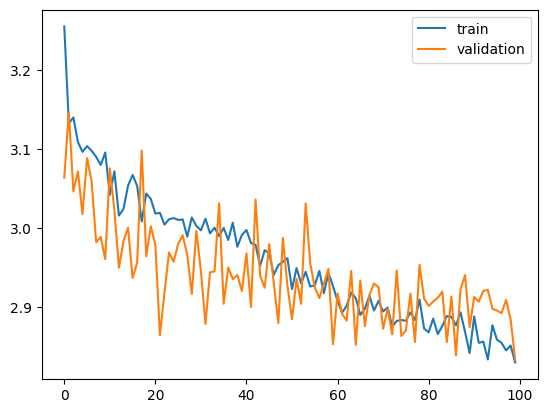

In [8]:
plt.plot(training_losses, label="train")
plt.plot(validation_losses, label="validation")
plt.legend()
plt.show()

In [9]:
def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for data, label in dataloader:
            feature = model(data[0])
            features.append(feature)
            labels.append(label)

    features = torch.cat(features, dim=0).cpu().numpy()
    labels = torch.cat(labels, dim=0).cpu().numpy()
    return features, labels

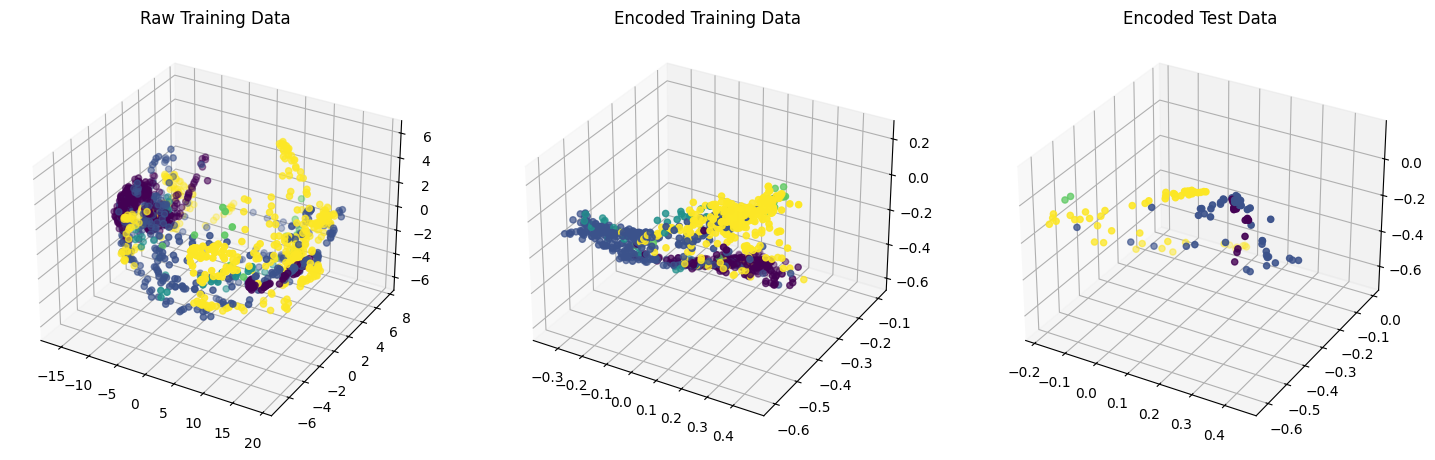

In [10]:
X_train_embed, y_train_embed = extract_features(model, train_dataloader)
X_val_embed, y_val_embed = extract_features(model, val_dataloader)
X_test_embed, y_test_embed = extract_features(model, test_dataloader)

fig = plt.figure(figsize=(18, 6)) 
ax = fig.add_subplot(131, projection='3d')
ax.set_title('Raw Training Data')
scatter = ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=y_train, cmap='viridis')
ax = fig.add_subplot(132, projection='3d')
ax.set_title('Encoded Training Data')
scatter = ax.scatter(X_train_embed[:, 0], X_train_embed[:, 1], X_train_embed[:, 2], c=y_train_embed, cmap='viridis')
ax = fig.add_subplot(133, projection='3d')
ax.set_title('Encoded Test Data')
scatter = ax.scatter(X_test_embed[:, 0], X_test_embed[:, 1], X_test_embed[:, 2], c=y_test_embed, cmap='viridis')
plt.show()

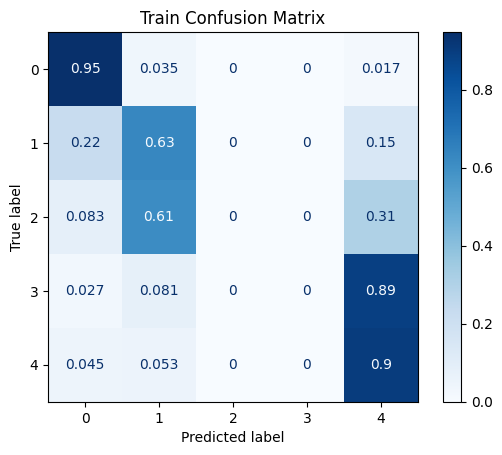

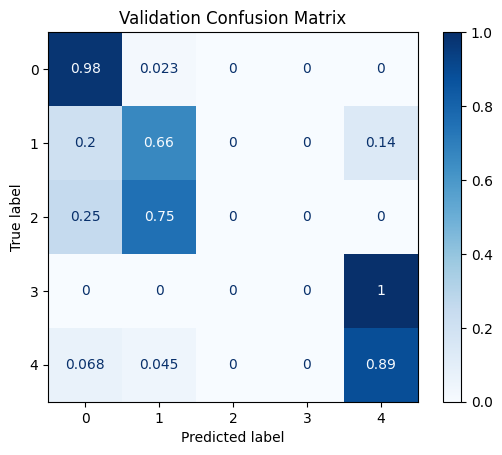

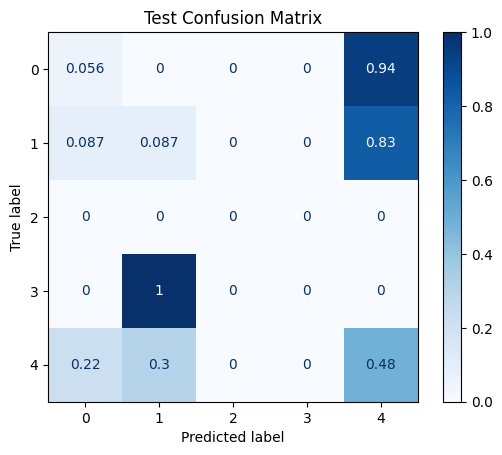

Accuracy of the model on the test set: 26.98%
Test accuracy: 26.984126984126984%


In [11]:
input_size = 3
num_classes = 5
# concat train and val
X_train_embed = np.vstack([X_train_embed, X_val_embed])
y_train_embed = np.hstack([y_train_embed, y_val_embed])

mlp = MLP(X=X_train_embed, y=y_train_embed, input_size=input_size, hidden_size=64, num_classes=num_classes, batch_size=32, learning_rate=0.001, num_epochs=100, model_save_path='mlp_model_3.pth')
mlp.train()

test_accuracy = mlp.test(X_test_embed, y_test_embed)
print(f'Test accuracy: {test_accuracy}%')